In [4]:
%matplotlib inline

%matplotlib inline
%load_ext autoreload
%autoreload 2

import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import regionmask
import pandas as pd
#from geopy.geocoders import Nominatim
from matplotlib.colors import SymLogNorm
from matplotlib.pyplot import cm

import xesmf as xe
#from pykrige.ok import OrdinaryKriging
import cartopy.crs as ccrs
import cartopy.feature as cfeat
import dask
import utils
import cmocean


import cartopy.feature
from cartopy.mpl.patch import geos_to_path
import cartopy.crs as ccrs

import geopandas

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
## look at https://wedocs.unep.org/bitstream/handle/20.500.11822/11406/Pog_&amp;_iPog_-_Energy_and_Fuels.pdf?sequence=1&amp%3BisAllowed=

## for emissions factors scaling

## fix tott

## Set constants

In [6]:
coal_year_range = np.arange(0,41)
percents = [0, 10, 20,30,40,50,60, 70,80,90, 99]
years = [0,10,20, 30]#
coal_year_range = np.arange(0,41)

In [7]:
## Add time dimension
length_simulation = 50*365

time_array = np.arange(0, length_simulation)

## Data read in

### Emissions dataframe

In [8]:
CGP_df = pd.read_csv('mod_coal_inputs/BC_limited_country_SEA_GAINS_Springer.csv')

In [9]:
CGP_df.columns = CGP_df.columns.str.replace(' ', '_')

In [10]:
CGP_df = CGP_df.rename(columns = {'YEAR':'Year_of_Commission', 'EMISFACTOR.PLATTS':'CO2_weighted_capacity_1000tonsperMW'})

### Convolution

In [11]:
da = {}
for yr in years:
    print(yr)
    da[yr] = {}
    for pc in percents:
        print(yr, pc)
        da[yr][pc] = xr.open_mfdataset(f'Outputs/C_out_{pc}_{yr}.nc', chunks = 'auto')
        


0
0 0
0 10
0 20
0 30
0 40
0 50
0 60
0 70
0 80
0 90
0 99
10
10 0
10 10
10 20
10 30
10 40
10 50
10 60
10 70
10 80
10 90
10 99
20
20 0
20 10
20 20
20 30
20 40
20 50
20 60
20 70
20 80
20 90
20 99
30
30 0
30 10
30 20
30 30
30 40
30 50
30 60
30 70
30 80
30 90
30 99


In [12]:
da2 = {}
for pc in percents:
    da2[pc] = xr.concat([da[yr][pc] for yr in years], pd.Index([yr for yr in years], name = 'year_shutdown'))
    
ds = xr.concat([da2[pc] for pc in percents], pd.Index([pc for pc in percents], name = 'percent'))
ds = ds.rename({'__xarray_dataarray_variable__':'BC_conc'})
ds['BC_conc']*=1e9
ds['BC_conc'].attrs = {'units':'ppb'}

In [13]:
def ppb_to_ug(ds, species_to_convert, mw_species_list, stp_p = 101325, stp_t = 298.):
    '''Convert species to ug/m3 from ppb'''
    R = 8.314 #J/K/mol
    ppb_ugm3 = (stp_p / stp_t / R) #Pa/K/(J/K/mol) = g/m^3

    for spec in species_to_convert:
        attrs = ds[spec].attrs
        ds[spec] = ds[spec]*mw_species_list[spec]*ppb_ugm3 #ppb*g/mol*g/m^3
        ds[spec].attrs['units'] = 'μg m-3'
    #return(ds)

mw_BC = {'BC_conc':12.011}
ppb_to_ug(ds, ['BC_conc'], mw_BC)

In [14]:
ds['percent'] = 100- ds['percent']

### Area for weighting

In [15]:
ds_area = xr.open_dataset('/net/fs11/d0/emfreese/GCrundirs/IRF_runs/stretch_2x_pulse/SEA/Jan/mod_output/GEOSChem.SpeciesConc.20160101_0000z.nc4', engine = 'netcdf4')

In [16]:
ds_area = utils.fix_area_ij_latlon(ds_area)

## Mortality calculations

In [17]:
# RR: 1·08 (95% CI 1·06–1·09) https://www.thelancet.com/journals/lanpub/article/PIIS2468-2667(18)30144-0/fulltext

In [18]:
#GBD mortality rate 2019 mid 932.08 high 1,058.34 low 812.67

In [19]:
RR = 1.08
del_x = 10 #ug/m3

In [20]:
beta = np.log(RR)/del_x

In [21]:
I_val = 10462043.68

In [22]:
#population from CIESIN

### Import Population Density and Land Area Datasets

In [23]:
#### import our dataset for population density ####
pop_ds = xr.open_dataset("/net/fs11/d0/emfreese/population_data/gpw-v4-population-density-adjusted-to-2015-unwpp-country-totals-rev11_totpop_2pt5_min_nc/gpw_v4_population_density_adjusted_rev11_2pt5_min.nc").sel(raster = 4) #density in persons / sq km
pop_ds = pop_ds.rename({'latitude':'lat', 'longitude':'lon'})

pop_ds = pop_ds.assign_coords(coords = {'lat':pop_ds['lat']}) #fix the lat
pop_ds = pop_ds.fillna(0) 
pop_ds = pop_ds.rename({'UN WPP-Adjusted Population Density, v4.11 (2000, 2005, 2010, 2015, 2020): 2.5 arc-minutes':'pop_density'})

In [24]:
#### import our dataset for land area ####
land_ds = xr.open_dataset("/net/fs11/d0/emfreese/population_data/gpw-v4-population-density-adjusted-to-2015-unwpp-country-totals-rev11_totpop_2pt5_min_nc/gpw_v4_population_density_adjusted_rev11_2pt5_min.nc").sel(raster = 9) #density in persons / sq km
land_ds = land_ds.rename({'latitude':'lat', 'longitude':'lon'})

land_ds = land_ds.assign_coords(coords = {'lat':land_ds['lat']}) #fix the lat
land_ds = land_ds.fillna(0) 
land_ds = land_ds.rename({'UN WPP-Adjusted Population Density, v4.11 (2000, 2005, 2010, 2015, 2020): 2.5 arc-minutes':'land_area'})

## Merge Land and Population Datasets, Calculate Total Area

In [25]:
#### merge our pop and land area datasets ####
land_pop_ds = xr.merge([pop_ds, land_ds], compat='override')

In [26]:
#### create lat and lon bounds ####
lonb = land_pop_ds['lon'].values + (land_pop_ds['lon'][0]-land_pop_ds['lon'][1]).values/2
lonb = np.append(lonb, (lonb[-1] - (land_pop_ds['lon'][0]-land_pop_ds['lon'][1]).values))

latb = land_pop_ds['lat'].values + (land_pop_ds['lat'][0]-land_pop_ds['lat'][1]).values/2
latb = np.append(latb, (latb[-1] - (land_pop_ds['lat'][0]-land_pop_ds['lat'][1]).values))

land_pop_ds['lon_b'] = lonb
land_pop_ds['lat_b'] = latb

In [27]:
def find_area(ds, R = 6378.1):
    """ ds is the dataset, i is the number of longitudes to assess, j is the number of latitudes, and R is the radius of the earth in km. 
    Must have the ds['lat'] in descending order (90...-90)
    Returns Area of Grid cell in km"""
    
    dy = (ds['lat_b']- ds['lat_b'].roll({'lat_b':-1}, roll_coords = False))[:-1]*2*np.pi*R/360 

    dx1 = (ds['lon_b'].roll({'lon_b':-1}, roll_coords = False) - 
           ds['lon_b'])[:-1]*2*np.pi*R*np.cos(np.deg2rad(ds['lat_b']))
    
    dx2 = (ds['lon_b'].roll({'lon_b':-1}, roll_coords = False) - 
           ds['lon_b'])[:-1]*2*np.pi*R*np.cos(np.deg2rad(ds['lat_b'].roll({'lat_b':-1}, roll_coords = False)[:-1]))
    
    A = .5*(dx1+dx2)*dy
    
    #### assign new lat and lon coords based on the center of the grid box instead of edges ####
    A = A.assign_coords(lon_b = ds.lon.values,
                    lat_b = ds.lat.values)
    A = A.rename({'lon_b':'lon','lat_b':'lat'})

    A = A.transpose()
    
    return(A)

In [28]:
#### find the area of our original grid cells ####
A = find_area(land_pop_ds)



In [29]:
#### merge to create a new ds with all of our original land and population data ####
orig_ds = xr.merge([land_pop_ds, A.to_dataset(name = 'orig_total_area')])

orig_ds['land_area_ratio'] = orig_ds['land_area']/orig_ds['orig_total_area']
orig_ds['orig_pop_count'] = orig_ds['pop_density']* orig_ds['land_area']


## Regrid our dataset

In [30]:

def make_2d_grid(lon_b1, lon_b2, lon_step, lat_b1, lat_b2, lat_step):
    lon_bounds = np.arange(lon_b1, lon_b2+lon_step, lon_step)
    lon_centers = (lon_bounds[:-1] + lon_bounds[1:])/2
    
    lat_bounds = np.arange(lat_b1, lat_b2+lat_step, lat_step)[::-1]
    lat_centers = (lat_bounds[:-1] + lat_bounds[1:])/2
    
    ds = xr.Dataset({'lat': (['lat'], lat_centers),
                     'lon': (['lon'], lon_centers),
                     'lat_b': (['lat_b'], lat_bounds),
                     'lon_b': (['lon_b'], lon_bounds),
                    }
                   )
    return(ds)

In [31]:
#make a ds with grid for output and grid for input 
lat_dif = ds.lat.diff(dim = 'lat')[0].values
lon_dif = ds.lon.diff(dim = 'lon')[0].values
ds_out = make_2d_grid(-180, 180, lon_dif, 90, -90, -lat_dif) #grid that we want to regrid to
ds_in = make_2d_grid(-180, 180, .041666667, -90, 90, .041666667) #same as the grid for orig_ds

In [32]:
#create regridder (reusing weights)
regridder = xe.Regridder(ds_in, ds_out, 'conservative', reuse_weights = True, weights = 'conservative_health_area.nc')
regridder  # print basic regridder information.



/home/emfreese/anaconda3/envs/gchp/lib/python3.9/site-packages/xesmf/backend.py:53: UserWarning: Latitude is outside of [-90, 90]
  warnings.warn('Latitude is outside of [-90, 90]')


xESMF Regridder 
Regridding algorithm:       conservative 
Weight filename:            conservative_4320x8640_180x288.nc 
Reuse pre-computed weights? True 
Input grid shape:           (4320, 8640) 
Output grid shape:          (180, 288) 
Periodic in longitude?      False

regridder.to_netcdf('conservative_health_area.nc')

In [33]:
#regrid according to our ds_out grid
regrid_ds = regridder(orig_ds)

#update the latb and lonb so that they match the ds_out values
regrid_ds['lon_b'] = ds_out['lon_b']
regrid_ds['lat_b'] = ds_out['lat_b']

regrid_ds #look at our regridded dataset

/home/emfreese/anaconda3/envs/gchp/lib/python3.9/site-packages/xesmf/frontend.py:555: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  ds_out = xr.apply_ufunc(
/home/emfreese/anaconda3/envs/gchp/lib/python3.9/site-packages/xesmf/smm.py:98: UserWarning: Input array is not C_CONTIGUOUS. Will affect performance.
  warnings.warn('Input array is not C_CONTIGUOUS. ' 'Will affect performance.')


<xarray.Dataset>
Dimensions:          (lat: 180, lon: 288, lon_b: 289, lat_b: 181)
Coordinates:
    raster           int32 4
  * lon_b            (lon_b) float64 -180.0 -178.8 -177.5 ... 177.5 178.8 180.0
  * lat_b            (lat_b) float64 -90.0 -89.0 -88.0 -87.0 ... 88.0 89.0 90.0
  * lon              (lon) float64 -179.4 -178.1 -176.9 ... 176.9 178.1 179.4
  * lat              (lat) float64 -89.5 -88.5 -87.5 -86.5 ... 87.5 88.5 89.5
Data variables:
    pop_density      (lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    land_area        (lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    orig_total_area  (lat, lon) float64 90.07 90.07 90.07 ... 90.07 90.07 90.07
    land_area_ratio  (lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    orig_pop_count   (lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
Attributes:
    regrid_method:  conservative

In [34]:
#### find the area of our original grid cells ####
A = find_area(regrid_ds)

Area_ds = A.to_dataset(name = 'regrid_total_area')
Area_ds = Area_ds*-1

regrid_area_ds = xr.merge([regrid_ds, Area_ds])
regrid_area_ds = regrid_area_ds.drop(['orig_pop_count', 'land_area', 'orig_total_area'])

In [35]:
#### create new variables in regridded ds ####

regrid_area_ds['regrid_land_area'] = regrid_area_ds['land_area_ratio'] * regrid_area_ds['regrid_total_area'] 

regrid_area_ds['regrid_pop_count'] = regrid_area_ds['regrid_land_area'] * regrid_area_ds['pop_density']

In [36]:
#### check that we still have ~7 billion population ####
print(regrid_area_ds['regrid_pop_count'].sum(), orig_ds['orig_pop_count'].sum())

<xarray.DataArray 'regrid_pop_count' ()>
array(6.77842174e+09)
Coordinates:
    raster   int32 4 <xarray.DataArray 'orig_pop_count' ()>
array(7.3493243e+09, dtype=float32)
Coordinates:
    raster   int32 4


### Mortality calc

In [37]:
ds_base = xr.open_dataset(f'Outputs/C_out_{100}_{40}.nc')#('/net/fs03/d1/emfreese/BC-IRF/Outputs/Retirements/C_out_age_retirement_40.nc')

In [38]:
ds_base = ds_base.rename({'__xarray_dataarray_variable__':'BC_conc'})

In [39]:
ppb_to_ug(ds_base, ['BC_conc'], mw_BC)

In [40]:
ds['AF'] = (np.exp(beta*(ds['BC_conc']- ds_base['BC_conc'])) - 1)/np.exp(beta*(ds['BC_conc']- ds_base['BC_conc']))

In [41]:
I_obs = I_val/1.408e9

In [42]:
ds['delta_I'] = ds['AF']*regrid_area_ds['regrid_pop_count']*I_obs

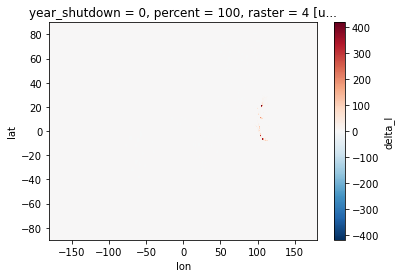

In [43]:
(ds['delta_I'].sel(year_shutdown = 0, percent = 100).sum(dim = 's')).plot()

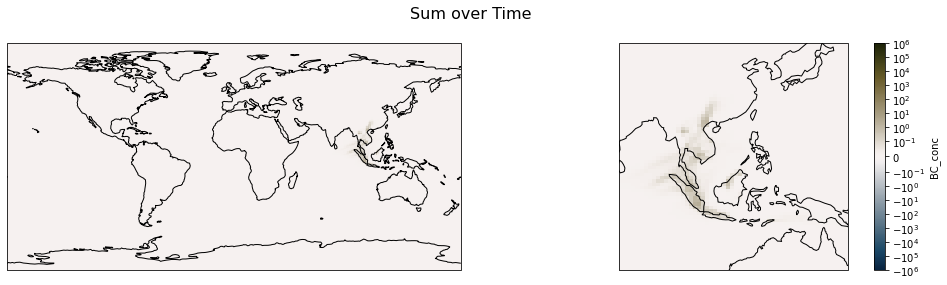

In [44]:

fig, (ax1, ax2) = plt.subplots(1,2, figsize = [14,4], subplot_kw={'projection':ccrs.PlateCarree()})
##### global view #######
(ds['BC_conc'].sel(year_shutdown = 0, percent = 100).sum(dim = 's')).plot(ax = ax1, transform = ccrs.PlateCarree(), 
                                                                            norm = SymLogNorm(1e-1, 1, -1e6, 1e6), add_colorbar = False,
                                                                           cmap = cmocean.cm.diff)
ax1.coastlines()
ax1.set_title('')
##### Zoomed in ########
(ds['BC_conc'].sel(year_shutdown = 0, percent = 100).sum(dim = 's')).plot(ax = ax2, transform = ccrs.PlateCarree(), 
                                                                            norm = SymLogNorm(1e-1, 1, -1e6, 1e6),
                                                                           cmap = cmocean.cm.diff)
ax2.coastlines()
ax2.add_feature(cfeat.STATES)
ax2.set_extent([80,150,-20,40])
ax2.set_title('')
plt.suptitle(f'Sum over Time', fontsize = 16);
plt.tight_layout()
plt.savefig("figures/0_100_yr_pct.png", dpi = 350, bbox_inches = 'tight')
#plt.close();

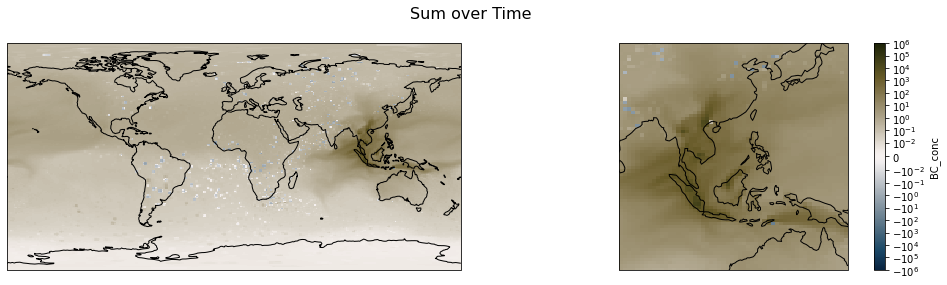

In [45]:

fig, (ax1, ax2) = plt.subplots(1,2, figsize = [14,4], subplot_kw={'projection':ccrs.PlateCarree()})
##### global view #######
(ds['BC_conc'].sel(year_shutdown = 30, percent = 1).sum(dim = 's')).plot(ax = ax1, transform = ccrs.PlateCarree(), 
                                                                            norm = SymLogNorm(1e-1, 1, -1e6, 1e6), add_colorbar = False,
                                                                           cmap = cmocean.cm.diff)
ax1.coastlines()
ax1.set_title('')
##### Zoomed in ########
(ds['BC_conc'].sel(year_shutdown = 30, percent = 1).sum(dim = 's')).plot(ax = ax2, transform = ccrs.PlateCarree(), 
                                                                            norm = SymLogNorm(1e-2, 1, -1e6, 1e6),
                                                                           cmap = cmocean.cm.diff)
ax2.coastlines()
ax2.add_feature(cfeat.STATES)
ax2.set_extent([80,150,-20,40])
ax2.set_title('')
plt.suptitle(f'Sum over Time', fontsize = 16);
plt.tight_layout()
plt.savefig("figures/30_1_yr_pct.png", dpi = 350, bbox_inches = 'tight')
#plt.close();

### Country Mask

In [47]:
country_mask = regionmask.defined_regions.natural_earth_v5_0_0.countries_110
countries = ['China']#,'Indonesia','Malaysia','Vietnam','Australia', 'Cambodia','Myanmar', 'Laos','Philippines','Nepal','Bangladesh','Thailand','Bhutan']
print('countries uploaded')

countries uploaded


## Dataframes by country exposure (sum and mean)

In [48]:
percents = [100-p for p in percents]

In [49]:
percents

[100, 90, 80, 70, 60, 50, 40, 30, 20, 10, 1]

In [50]:
mask = country_mask.mask(ds, lon_name = 'lon', lat_name = 'lat')
contiguous_mask = ~np.isnan(mask)& (mask == country_mask.map_keys(countries))

In [51]:
China_ds = ds.where(contiguous_mask).weighted(ds_area['area']).mean(dim = ['lat','lon']).sum(dim = ['s'])


In [52]:
print(China_ds['delta_I'].values)

[[6.59545705e-01 2.40733653e+03 4.81401337e+03 7.22069021e+03]
 [5.53755672e+02 2.84980736e+03 5.14585892e+03 7.44191047e+03]
 [5.53755672e+02 2.84980736e+03 5.14585892e+03 7.44191047e+03]
 [5.53755672e+02 2.84980736e+03 5.14585892e+03 7.44191047e+03]
 [5.53755672e+02 2.84980736e+03 5.14585892e+03 7.44191047e+03]
 [5.53755672e+02 2.84980736e+03 5.14585892e+03 7.44191047e+03]
 [5.53755672e+02 2.84980736e+03 5.14585892e+03 7.44191047e+03]
 [5.34858644e+03 6.43418734e+03 7.51978819e+03 8.60538904e+03]
 [5.34858644e+03 6.43418734e+03 7.51978819e+03 8.60538904e+03]
 [9.33407543e+03 9.52134850e+03 9.70862157e+03 9.89589463e+03]
 [9.98371594e+03 1.00410538e+04 1.00983917e+04 1.01557296e+04]]


In [52]:
China_ds

<xarray.Dataset>
Dimensions:        (year_shutdown: 1, percent: 1)
Coordinates:
  * year_shutdown  (year_shutdown) int64 30
  * percent        (percent) int64 80
    raster         int32 4
Data variables:
    BC_conc        (percent, year_shutdown) float64 dask.array<chunksize=(1, 1), meta=np.ndarray>
    AF             (percent, year_shutdown) float64 dask.array<chunksize=(1, 1), meta=np.ndarray>
    delta_I        (percent, year_shutdown) float64 dask.array<chunksize=(1, 1), meta=np.ndarray>

In [ ]:
China_ds.to_netcdf(f'Outputs/China_early_shutdown_co2pct_mort_mean.nc')